In [1]:
# Imports
import numpy as np
import matplotlib.pyplot as plt
import math
from scipy.optimize import fsolve

In [2]:
# Paramètres
nx, ny = 100, 50 # Mise à jour des valeurs de nx et ny
Lx, Ly = 10, 5   # Mise à jour des valeurs de Lx et Ly
nt = 1000
dt = 50
dx = Lx/(nx-1)
dy = Ly/(ny-1)
h = 10
T0, T1, Ta = 273.15, 373.15, 293.15  #Températures en Kelvin (initiale, au bord, et ambiante)
k = 380.0  # Conductivité thermique du cuivre en W/(m·K)
rho = 8960.0  # Densité du cuivre en kg/m³
cp = 385.0  # Capacité thermique du cuivre en J/(kg·K)
alpha = k / (rho * cp)  # Diffusivité thermique du cuivre en m²/s

In [3]:
# Definition of functions
def equation(x, L, h, l):
    return x * np.tan(L * x) - h / l

def find_first_n_solutions(L, h, l, n):
    solutions = []
    guess = 0.1
    while len(solutions) < n:
        solution = fsolve(equation, guess, args=(L, h, l))
        solution = solution[0]  # Convertir la solution en un nombre réel
        if not any(abs(sol - solution) < 1e-7 for sol in solutions):  # Vérifier si la solution est déjà dans la liste
            solutions.append(solution)
        guess += 0.1  # Augmenter la supposition initiale pour la prochaine solution
    return solutions

def serie(Lx, Ly, h, l, x, y, n):
    sum = 0
    for k in range(0, n+1):
        a = liste_solutions[k]
        x_k = (np.cos(a*x)*np.cosh(a*(Ly-y)))/(((a**2+(h/l)**2)*Lx+h/l)*np.cos(a*Lx)*np.cosh(a*Ly))
        print(x_k)
        sum += x_k
    print("sum =", sum)
    return sum

def generate_analytical_profile(nx, ny, Lx, Ly, T1, Ta, h, k, n):
    # Définir les pas en x et y
    dx = 0.15*Lx/(nx-1)
    dy = 0.15*Ly/(ny-1)

    # Créer des grilles de points x et y
    x = np.linspace(0, Lx, nx)
    y = np.linspace(0, Ly, ny)

    # Initialiser le profil analytique
    T_analytical = np.zeros((nx, ny))

    # Calculer le profil analytique en utilisant une formule spécifique
    for i in range(nx):
        for j in range(ny):
            x = i/nx
            y = j/ny
            # Mettre en œuvre la formule analytique en fonction de x, y et d'autres paramètres
            sum = serie(Lx, Ly, h, k, x, y, n)
            T_analytical[i, j] = (Ta + 2*(T1-Ta)*sum*10/401)

    # Tracer le profil analytique
    fig, ax = plt.subplots(figsize=(6, 6))
    im = ax.imshow(T_analytical, cmap='hot', interpolation='nearest')
    colorbar = fig.colorbar(im, ax=ax)
    colorbar.set_label('Température')
    # plt.imshow(T_analytical, cmap='hot', origin='lower', extent=[0, Lx, 0, Ly])
    # plt.colorbar(label='Température')
    # plt.xlabel('x')
    # plt.ylabel('y')
    # plt.title('Profil de température analytique')
    # plt.gca().set_ylim(50, 0)
    plt.show()
    return T_analytical

# Méthode TDMA
def TDMA(a, b, c, d):
    n = len(d)
    w = np.zeros(n-1,float)
    g = np.zeros(n, float)
    p = np.zeros(n,float)

    w[0] = c[0]/b[0]
    g[0] = d[0]/b[0]

    for i in range(1,n-1):
        w[i] = c[i]/(b[i] - a[i-1]*w[i-1])
    for i in range(1,n):
        g[i] = (d[i] - a[i-1]*g[i-1])/(b[i] - a[i-1]*w[i-1])
    p[n-1] = g[n-1]
    for i in range(n-1,0,-1):
        p[i-1] = g[i-1] - w[i-1]*p[i]
    return p

# Méthode ADI
def ADI_method(T, nx, ny, nt, dt, dx, dy, alpha, T1, h, Ta, k):
    # Créer la figure en dehors de la boucle
    fig, ax = plt.subplots(figsize=(6, 6))
    im = ax.imshow(T, cmap='hot', interpolation='nearest')
    colorbar = fig.colorbar(im, ax=ax)
    colorbar.set_label('Température')

    it = 0
    while it < nt:
        T_old = T.copy()

        # Étape 1 : résoudre dans la direction x
        for j in range(1, ny-1):
            a = np.full(nx-1, -alpha*dt/(2*dx**2))
            b = np.full(nx-1, 1 + alpha*dt/(dx**2))
            c = np.full(nx-1, -alpha*dt/(2*dx**2))
            d = T_old[1:-1, j] + alpha*dt/(2*dy**2) * (T_old[1:-1, j+1] - 2*T_old[1:-1, j] + T_old[1:-1, j-1])

            # Appliquer les conditions aux limites
            d[0] += alpha*dt/(2*dx**2) * T_old[0, j]
            d[-1] += alpha*dt/(2*dx**2) * (2*dx*h*(Ta-T_old[-1, j])/(2*dx*h+alpha) + T_old[-2, j])

            T[1:-1, j] = TDMA(a, b, c, d)

        # Appliquer la condition de conducto-convection à x = Lx
        T[-1, :] = (2*dx*h*Ta + k*T[-2, :]) / (2*dx*h + k)

        T_old = T.copy()

        # Étape 2 : résoudre dans la direction y
        for i in range(1, nx-1):
            a = np.full(ny-1, -alpha*dt/(2*dy**2))
            b = np.full(ny-1, 1 + alpha*dt/(dy**2))
            c = np.full(ny-1, -alpha*dt/(2*dy**2))
            d = T_old[i, 1:-1] + alpha*dt/(2*dx**2) * (T_old[i+1, 1:-1] - 2*T_old[i, 1:-1] + T_old[i-1, 1:-1])

            # Appliquer les conditions aux limites
            d[0] += alpha*dt/(2*dy**2) * T1
            d[-1] += alpha*dt/(2*dy**2) * T_old[i, -2]

            T[i, 1:-1] = TDMA(a, b, c, d)

        # Mettre à jour l'image à chaque étape
        im.set_data(T)
        ax.set_title(f"Profil de température à l'étape {it+1}")
        plt.pause(0.01)
        nt += dt

    return T

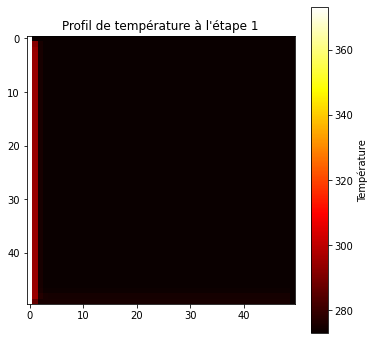

[[373.15       273.15       273.15       ... 273.15       273.15
  273.17145923]
 [373.15       323.09007087 303.26505646 ... 273.24454    273.21592642
  273.17145923]
 [373.15       342.79543673 322.91070326 ... 273.3375865  273.2782512
  273.17145923]
 ...
 [373.15       353.94001902 340.42175459 ... 283.11409835 280.49042556
  273.17145923]
 [373.15       346.09499936 331.49140911 ... 285.26980252 282.80258008
  273.17145923]
 [373.06416309 342.95653086 329.21853664 ... 285.73678862 282.85171671
  273.19289543]]


In [4]:
# Solution numérique

# # # Initialiser le profil de température à T0
T = np.full((nx, ny), T0)

# Appliquer les conditions aux limites initiales
T[:, 0] = T1
T[0, :] = T[1, :]
T[-1, :] = T[-2, :]
T[:, -1] = (2*dy*h*Ta + k*T[:, -2]) / (2*dy*h + k)

# Exécuter la méthode ADI
T = ADI_method(T, nx, ny, nt, dt, dx, dy, alpha, T1, h, Ta, k)
print(T)

[0.1615133463256019, 3.14994681915841, 6.2873707825894245, 9.427569318778614, 12.56846440642214, 15.709638402931954, 18.850951913237072, 21.99234516315582, 25.13378825671064, 28.27526458206509, 31.41676417096236]
19.08256953277922
-0.10051437134901658
0.025279532746281908
-0.011247869557008072
sum = 18.99608682461948
19.072798781572672
-0.09440064462892915
0.02229246344406477
-0.009315012580326474
sum = 18.99137558780748
19.063227048031038
-0.08866170534847588
0.019658356501811768
-0.007714301721740632
sum = 18.986509397462633
19.053854232276784
-0.08327476889249237
0.017335505420594723
-0.006388660311381561
sum = 18.981526308493503
19.044680236508018
-0.07821844815997166
0.015287131896323213
-0.005290819851795177
sum = 18.976458100392573
19.035704964997453
-0.07347266865344847
0.013480803499309494
-0.004381634561502855
sum = 18.97133146528181
19.026928324091422
-0.0690185887796551
0.011887920163191274
-0.003628685550868508
sum = 18.966168969924087
19.01835022220889
-0.0648385250450265

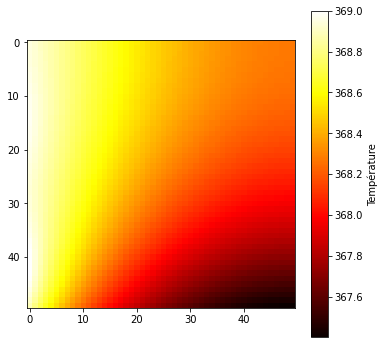

In [5]:
# Solution analytique
n_solutions = 11
liste_solutions = find_first_n_solutions(Lx, h, k, n_solutions)
print(liste_solutions)

T_analytical = generate_analytical_profile(nx, ny, Lx, Ly, T1, Ta, h, k, 3)

[[-4.26718414 95.65055016 95.5732622  ... 94.25674454 94.2544514
  94.23161695]
 [-4.23564213 45.74280983 65.4912157  ... 94.19988757 94.22620926
  94.26930196]
 [-4.20949032 26.06491776 45.87418436 ... 94.14360518 94.20065146
  94.30607066]
 ...
 [-4.20356924 14.98725427 28.48580362 ... 85.16109033 87.78312775
  95.1011124 ]
 [-4.20474251 22.83136941 37.41546801 ... 83.00636403 85.47195277
  95.10209296]
 [-4.11930294 25.96953134 39.68810933 ... 82.53970381 85.42314258
  95.08098353]]


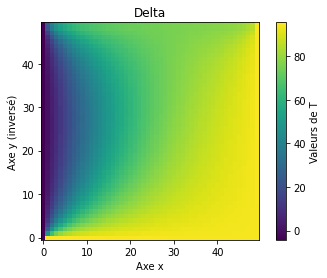

In [6]:
# Comparaison
T_inverse = np.flipud(T_analytical)
Delta = T_inverse - T
print(Delta)

plt.imshow(Delta, origin='lower')
plt.colorbar(label='Valeurs de T')
plt.xlabel('Axe x')
plt.ylabel('Axe y (inversé)')
plt.title('Delta')
plt.show()